# Warping `1` point forward.

In [1]:
# model_name = "Original_Pretrained_R2plus1DMotionSegNet.pth"

# model_name = "dropout_v2_0_25_R2plus1DMotionSegNet.pth"
model_name = "dropout_v3_0_10_R2plus1DMotionSegNet.pth"

In [2]:
import os
os.chdir("../..")
print(os.getcwd())

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads, forgot to define in forward pass function, but still saw diff, weird.)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet
# v3 dropout (one dropout layer defined in forward pass func, this should've been the correct way to do it.)
from src.model.dropout_v3_0_00_R2plus1D_18_MotionNet import dropout_v3_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_10_R2plus1D_18_MotionNet import dropout_v3_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_25_R2plus1D_18_MotionNet import dropout_v3_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_50_R2plus1D_18_MotionNet import dropout_v3_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_75_R2plus1D_18_MotionNet import dropout_v3_0_75_R2plus1D_18_MotionNet
# v4 dropout (4 dropout layers in different places in the forward func, I'm going to guess more "generalizable")
from src.model.dropout_v4_0_00_R2plus1D_18_MotionNet import dropout_v4_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_10_R2plus1D_18_MotionNet import dropout_v4_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_25_R2plus1D_18_MotionNet import dropout_v4_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_50_R2plus1D_18_MotionNet import dropout_v4_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_75_R2plus1D_18_MotionNet import dropout_v4_0_75_R2plus1D_18_MotionNet

# for finding lv seg borders
import cv2 as cv

# for storing vector snapshots
import copy

# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

# full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
# random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


100%|██████████| 16/16 [00:01<00:00, 14.31it/s]


In [3]:
model_save_path = f"save_models/{model_name}"
    
if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
    model_template_obj = R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_10_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_10_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_25_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_25_R2plus1D_18_MotionNet()


elif model_name == "dropout_v3_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


model = torch.nn.DataParallel(model_template_obj)

model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
model.eval();

dropout_v3_0_10_R2plus1DMotionSegNet.pth has 31575731 parameters.


In [4]:
from src.strain import *

In [5]:
%matplotlib widget

In [6]:
N = 3
test_pat_index = 0

curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(model = model,
                                                                                            test_dataset = test_dataset,
                                                                                            test_pat_index = test_pat_index)
    
ed_raw_seg_out = curr_clip_segmentations[:,0,...]

ed_one_hot_seg_out = one_hot(ed_raw_seg_out)


In [7]:
I = ed_one_hot_seg_out

I_regional_point_sets = image_to_regional_point_sets(I)

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking/src/strain.py:1072: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  I_regional_point_sets = np.array(I_regional_point_sets)


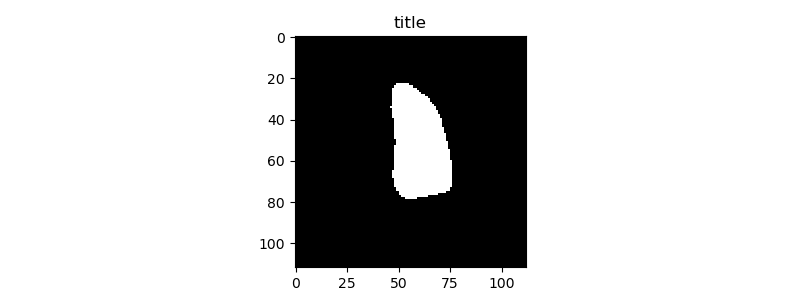

In [8]:
vis_single(I, cmap='gray')

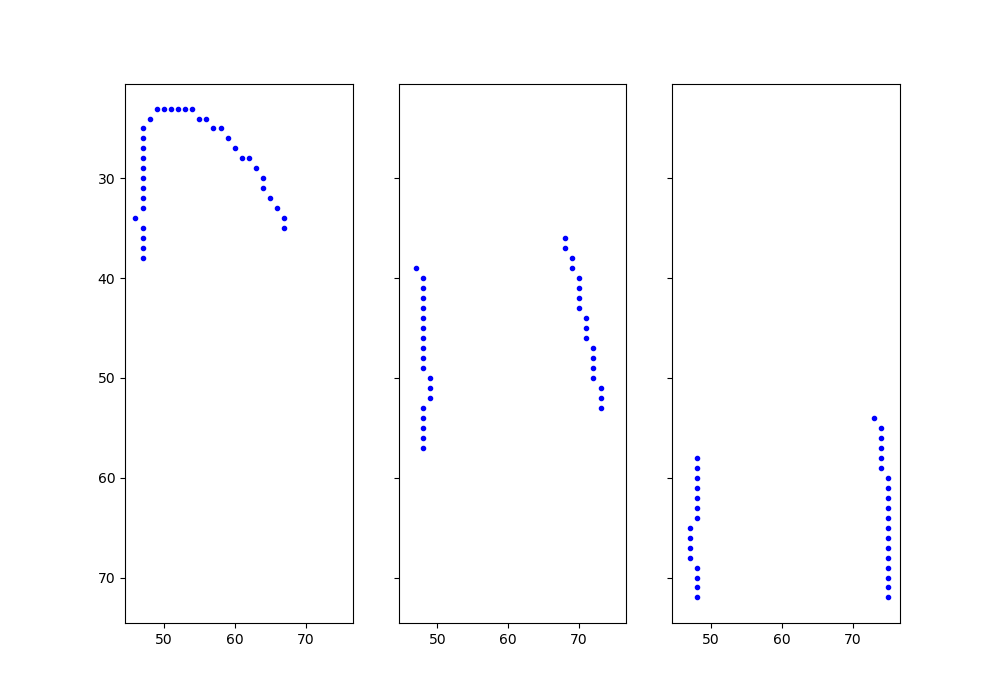

In [9]:
vis_three_point_sets(I_regional_point_sets)

In [10]:
for i in range(N):
    print(I_regional_point_sets[i].shape)

(36, 2)
(37, 2)
(34, 2)


In [11]:
delta_ed_es

16

## Warping the point set forward in time from frame `0` to frame `1` is easy. 
## Warping from frame `1` to further frames is difficult because we need to interpolate the vector fields from their integer locations to our frame `1` and beyond frames floating point positions

In [12]:
I_apical_point_set = I_regional_point_sets[0]

coords = I_apical_point_set

coords_multiple_frames = np.array([coords]).astype(float)

In [13]:
frame = 0

# warp forward all the current points
coords_1 = []
for _ in range(len(coords)):
    pair = coords[_]

    i_0,j_0 = pair[0],pair[1]

    # forward change in y
    delta_i = curr_clip_motions[1][frame][i_0][j_0]

    # forward change in x
    delta_j = curr_clip_motions[0][frame][i_0][j_0]

    i_1, j_1 = i_0 + delta_i , j_0 + delta_j
    
    # print(i_1, j_1)

    coords_1.append([i_1, j_1])

coords_1 = np.array(coords_1)

coords_multiple_frames = np.insert(coords_multiple_frames, 1, coords_1, axis=0)

coords_multiple_frames = coords_multiple_frames

In [14]:
coords_multiple_frames[0][0]

array([23., 49.])

In [15]:
curr_clip_motions.shape

(4, 32, 112, 112)

In [16]:
# the first vector from frame 0 -> 1 (don't be confused, storing the (i,j) and motion tracking (forward x,y) that gets us from ED to ED+1
# we already applied that information in the preliminary warp, so this is just redundantly storing that information
all_new_vectors = []

point_0 = coords_multiple_frames[0][0]
point_0_i = int(point_0[0])
point_0_j = int(point_0[1])

mag_x = curr_clip_motions[0][0][point_0_i][point_0_j]
mag_y = curr_clip_motions[1][0][point_0_i][point_0_j]
thing = Vector(point_0_j, point_0_i, mag_x, mag_y)
all_new_vectors.append(copy.deepcopy(thing))

In [17]:
# the next vector from frame 1 -> 2 (BUT, now we need to do interp to get correct magnitudes!)

point_1 = coords_multiple_frames[1][0] # one point at frame 1, need to now warp using frame 1 vectors
new_vector = Vector(point_1[1], point_1[0], 0, 0)
all_new_vectors.append(copy.deepcopy(new_vector))

In [18]:
# we already warped 1 frame, so let's warp for delta_ed_es - 1
for ind in range(1, delta_ed_es - 1):
    frame = ind
    
    inted_i, inted_j = int(new_vector.tail_y), int(new_vector.tail_x)
    surr_vec_tails = [ [inted_i, inted_j],
                         [inted_i, inted_j+1],
                         [inted_i+1, inted_j],
                         [inted_i+1, inted_j+1] ]
    
    surround_vectors = []

    for _ in surr_vec_tails:
        i,j = _[0], _[1]
        x = j
        y = i

        mag_i = curr_clip_motions[1][frame][i][j]
        mag_j = curr_clip_motions[0][frame][i][j]

        mag_x = mag_j
        mag_y = mag_i

        surround_vectors.append(Vector(x, y, mag_x, mag_y))
        
    new_vector = vector_bilinear_interpolation(surround_vectors, new_vector)
    
    new_vector.tail_x += new_vector.mag_x
    new_vector.tail_y += new_vector.mag_y
    
    all_new_vectors.append(copy.deepcopy(new_vector))
    
    new_vector.mag_x = None
    new_vector.mag_y = None

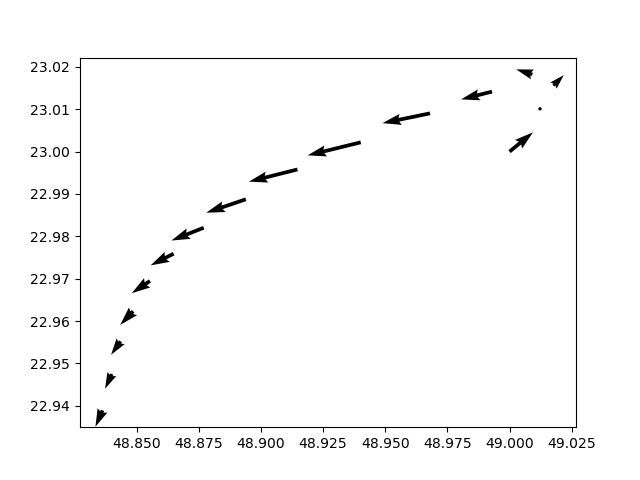

In [19]:
x_tails = []
y_tails = []
x_mags = []
y_mags = []

for v in all_new_vectors:
    x_tails.append(v.tail_x)
    y_tails.append(v.tail_y)

    x_mags.append(v.mag_x)
    y_mags.append(v.mag_y)

plt.figure()
plt.quiver(x_tails, y_tails, x_mags, y_mags, color='k', linewidth=0.7)

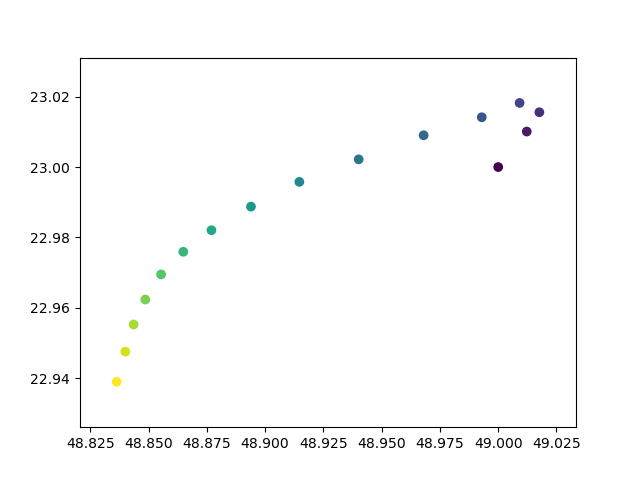

In [20]:
plt.figure()
plt.scatter(x_tails, y_tails, c=np.linspace(0,1,len(x_tails)))

In [21]:
len(x_tails)

16

In [22]:
delta_ed_es

16